In [414]:
import sys
sys.path.append(r'../')
import numpy as np
from scipy import signal
import mat73
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from mpl_toolkits import mplot3d
from matplotlib import cm
import matplotlib.animation as animation
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras.losses import Loss
from keras.utils.np_utils import to_categorical
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.linear_model import LinearRegression
%reload_ext autoreload
%autoreload 2
from functions import *

In [5]:
data = Database()
X = data.neuron_traces.T
B = data.states

## Preprocessing the data

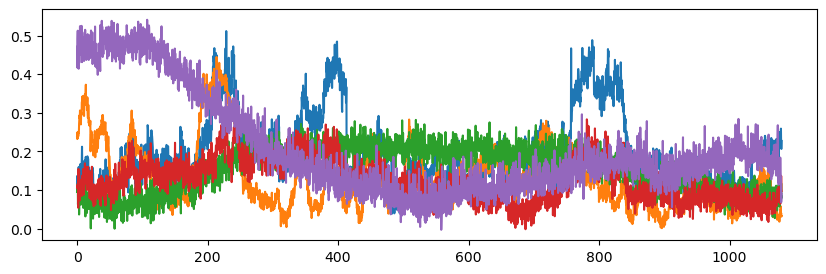

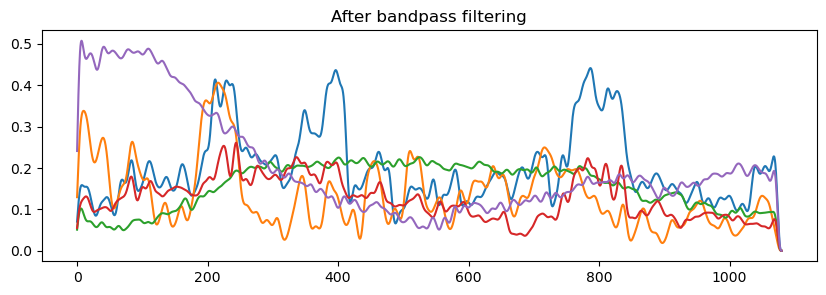

In [6]:
time = 1/data.fps*np.arange(0,X.shape[0])
filtered = bandpass(X.T, f_l=1e-10, f_h=0.05, sampling_freq=data.fps).T

nn = np.arange(80,85)
plt.figure(figsize = [10,3])
plt.plot(time, X[:,nn])
plt.figure(figsize = [10,3])
plt.plot(time, filtered[:,nn])
plt.title('After bandpass filtering')
plt.show()

X = filtered

### Preparing the data  

In [22]:
# Preparing the data (Method new)
win = 1
win += 1
gap = 1
X_win = np.zeros((X.shape[0]-win-gap, win, X.shape[1]))
for i, _ in enumerate(X_win):
    X_win[i] = X[i:i+win]

Xwin0, Xwin1 = X_win[:,:-1,:], X_win[:,1:,:]
B_1 = B[1:]
X_paired = np.array([Xwin0, Xwin1])
X_paired = np.transpose(X_paired, axes=(1,0,2,3))

# Train test split 
kf = KFold(n_splits=7)
for i, (train_index, test_index) in enumerate(kf.split(X_win)):
    if i==4: 
        # Train test split based on a fold
        X_train, X_test = X_paired[train_index], X_paired[test_index]
        B_train_1, B_test_1 = B_1[train_index], B_1[test_index]        

X0_tr = X_train[:,0,:,:]
X1_tr = X_train[:,1,:,:]
Xdiff_tr = X1_tr - X0_tr
X0_tst = X_test[:,0,:,:]
X1_tst = X_test[:,1,:,:]
Xdiff_tst = X1_tst - X0_tst

### 1. Mean as macrovariable

In [14]:
Y0_tr = X_train[:,0,0,:].mean(axis=1)[:,np.newaxis]
Y1_tr = X_train[:,1,0,:].mean(axis=1)[:,np.newaxis]
Ydiff_tr = Y1_tr - Y0_tr

Y0_tst = X_test[:,0,0,:].mean(axis=1)[:,np.newaxis]
Y1_tst = X_test[:,1,0,:].mean(axis=1)[:,np.newaxis]
Ydiff_tst = Y1_tst - Y0_tst

In [15]:
scaler = StandardScaler()
scaler.fit(Y0_tr)
Y0_tr, Y0_tst = scaler.transform(Y0_tr), scaler.transform(Y0_tst)
scaler.fit(Y1_tr)
Y1_tr, Y1_tst = scaler.transform(Y1_tr), scaler.transform(Y1_tst)
np.savetxt('Saved_Y/Y0_tr__mean.csv',Y0_tr)
np.savetxt('Saved_Y/Y1_tr__mean.csv',Y1_tr)
np.savetxt('Saved_Y/Y0_tst__mean.csv',Y0_tst)
np.savetxt('Saved_Y/Y1_tst__mean.csv',Y1_tst)
np.savetxt('Saved_Y/B_train_1__mean.csv',B_train_1)
np.savetxt('Saved_Y/B_test_1__mean.csv',B_test_1)

#### Plotting $Y$ dynamics


(0.0, 2674.0, -0.5, 0.5)

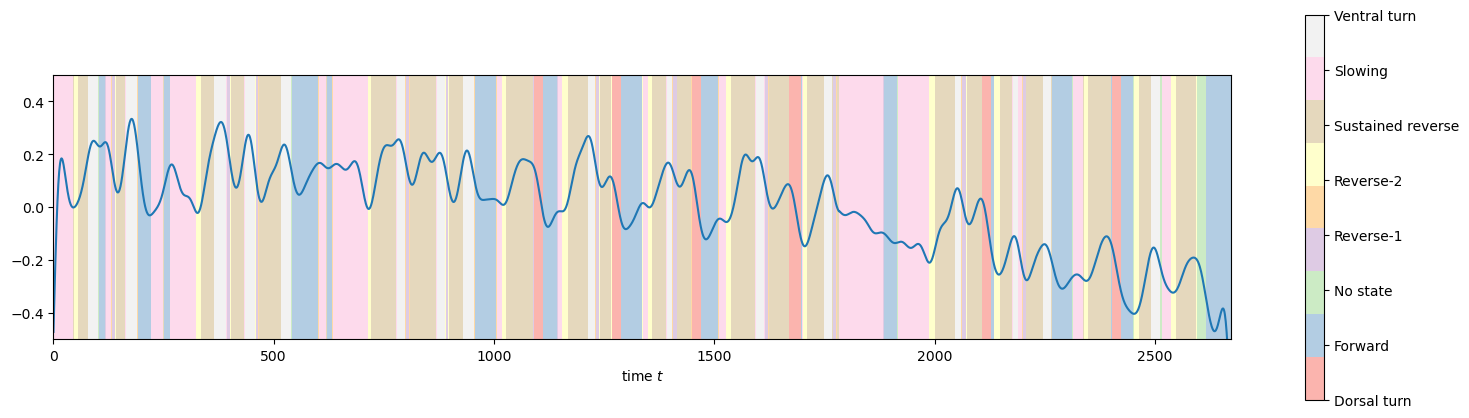

In [17]:
plt.figure(figsize=(19,5))
plt.imshow([B_train_1],aspect=600,cmap="Pastel1")
cbar = plt.colorbar(ticks=np.arange(8))
cbar.ax.set_yticklabels(['Dorsal turn', 'Forward', 'No state', 'Reverse-1', 'Reverse-2', 'Sustained reverse', 'Slowing', 'Ventral turn']) 
plt.plot(Y0_tr/Y0_tr.max()/3)
plt.xlabel("time $t$")
plt.axis([0,Y0_tr.shape[0],-0.5,0.5])

In [221]:
B_perm = np.random.choice(B_test_1, size=B_test_1.shape)
print('Chance prediction accuracy: ', accuracy_score(B_perm, B_test_1))

Chance prediction accuracy:  0.28475336322869954


### Autoregressor: Predicting $Y_{t+1}$ from $Y_t$

On training set 

Baseline error 0.00145 Mean square error: 0.00145

On test set 

Baseline error 0.02068 Mean square error: 0.03717


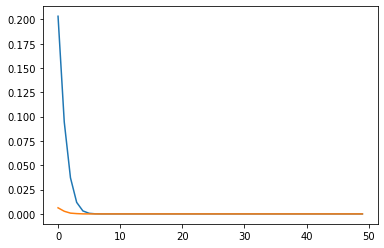

In [98]:
# Defining the model
model_ydiff_f_yt = tf.keras.Sequential([
    #tf.keras.layers.Dense(3, activation='relu'),
    #tf.keras.layers.Dense(5, activation='relu'),
    #tf.keras.layers.Dense(7, activation='relu'),
    #tf.keras.layers.Dense(10, activation='relu'),
    #tf.keras.layers.Dense(7, activation='relu'),
    #tf.keras.layers.Dense(5, activation='relu'),
    tf.keras.layers.Dense(3, activation='linear')
])

opt = tf.keras.optimizers.Adam(learning_rate=0.01)

model_ydiff_f_yt.compile(optimizer=opt,
              loss='mse',
              metrics=['mse'])


history = model_ydiff_f_yt.fit(Y0_tr,
                      Ydiff_tr,
                      epochs=50,
                      batch_size=100,
                      validation_data=(Y0_tst, Ydiff_tst),
                      verbose=0
                      )

# Summarize history for accuracy
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])


Ydiff_tr_pred = model_ydiff_f_yt(Y0_tr).numpy()
Y1_tr_pred = Y0_tr + Ydiff_tr_pred

Ydiff_tst_pred = model_ydiff_f_yt(Y0_tst).numpy()
Y1_tst_pred = Y0_tst + Ydiff_tst_pred

mse = tf.keras.metrics.MeanSquaredError()
print('On training set \n')
print('Baseline error', mse(Y1_tr, Y0_tr).numpy().round(5), 'Mean square error:', mse(Y1_tr, Y1_tr_pred).numpy().round(5))
print('\nOn test set \n')
print('Baseline error', mse(Y1_tst, Y0_tst).numpy().round(5), 'Mean square error:', mse(Y1_tst, Y1_tst_pred).numpy().round(5))

In [91]:
hits_at_rank(5,Y1_tr, Y1_tr_pred)

0.034779356768885564

### 2. Output of behaviour predictor as macrovariable

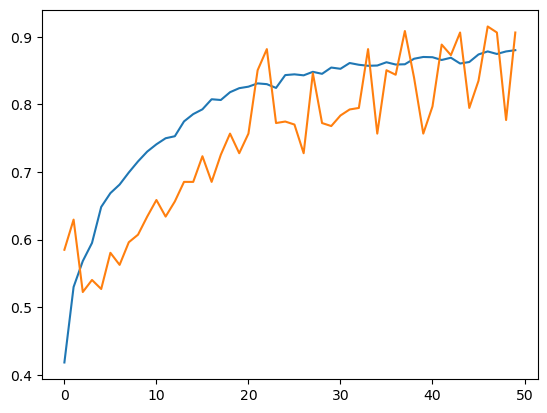

In [409]:
%matplotlib inline
b_predictor = tf.keras.Sequential([
    layers.Flatten(),
    layers.Dense(20, activation='relu'),
    layers.Dense(10, activation='relu'),
    layers.Dense(10, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(8)
])
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

b_predictor.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = b_predictor.fit(X0_tr,
                      B_train_1,
                      epochs=50,
                      batch_size=50,
                      validation_data=(X0_tst, B_test_1),
                      verbose=0
                      )

# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [424]:
Y1_tst

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [423]:
Y0_tr = b_predictor(X0_tr).numpy().argmax(axis=1).reshape(-1,1)
Y1_tr = b_predictor(X1_tr).numpy().argmax(axis=1).reshape(-1,1)
Y0_tst = b_predictor(X0_tst).numpy().argmax(axis=1).reshape(-1,1)
Y1_tst = b_predictor(X1_tst).numpy().argmax(axis=1).reshape(-1,1)
for Yn in ['Y0_tr', 'Y1_tr', 'Y0_tst', 'Y1_tst']:
    globals()[Yn] = to_categorical(globals()[Yn], num_classes=8)

np.savetxt('Saved_Y/Y0_tr__supB.csv',Y0_tr)
np.savetxt('Saved_Y/Y1_tr__supB.csv',Y1_tr)
np.savetxt('Saved_Y/Y0_tst__supB.csv',Y0_tst)
np.savetxt('Saved_Y/Y1_tst__supB.csv',Y1_tst)
np.savetxt('Saved_Y/B_train_1__supB.csv',B_train_1)
np.savetxt('Saved_Y/B_test_1__supB.csv',B_test_1)

accuracy_score(B1_tst_pred, B_test_1)
#plt.plot(B1_tst_pred)
#plt.plot(B_test_1)

0.8549107142857143

In [415]:
Y0_tr = to_categorical(Y0_tr, num_classes=8)

In [418]:
Y0_tr.shape

(2686, 1)